In [40]:
import neuralfoil as nf
import aerosandbox.numpy as np
import aerosandbox as asb
import aerosandbox.tools.pretty_plots as p
import matplotlib.pyplot as plt
import casadi as ca

In [18]:
coor_airfoil = asb.Airfoil("s1223")

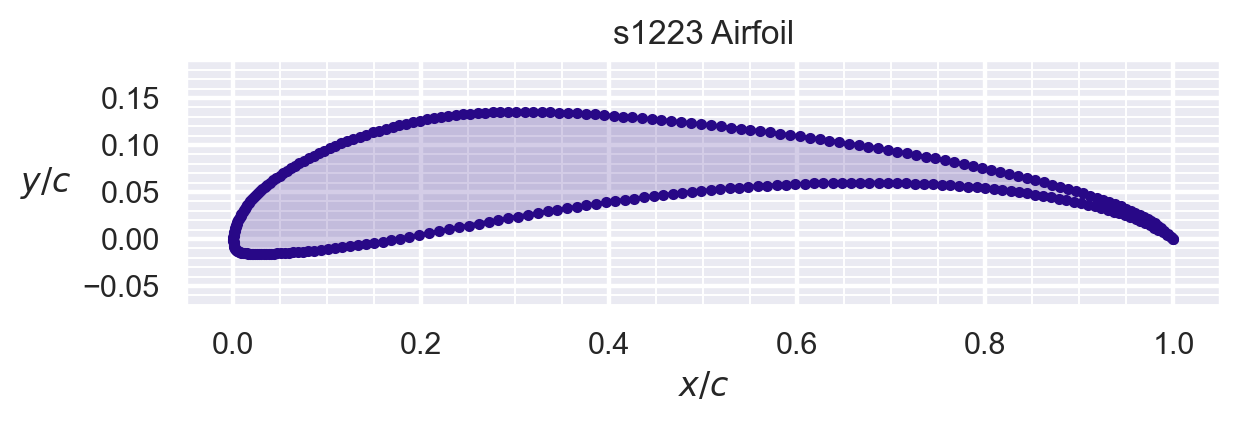

In [19]:
fig, ax = plt.subplots(figsize=(6,2))
coor_airfoil.draw()

# Airfoil shape optimization
Multipoint optimization.

Minimize $C_{D}$ at a given Reynolds number $Re_{c} = 5e5$ by changing the airfoil's shape and angle of attack $\alpha$. We can also maintain other constraints like specifying $C_{L}, C_{M}$, trailing-edge angle, leading-edge angle, etc.

In [20]:
# convert xy-coordinate airfoil to KulfanAirfoil with CST parameterization
# need KulfanAirfoil to do optimization
kulfan_airfoil = coor_airfoil.to_kulfan_airfoil()
print(kulfan_airfoil.kulfan_parameters)

{'lower_weights': array([-0.21118924, -0.12842562,  0.04467703,  0.30757855, -0.13588265,
        0.55798733,  0.02509871,  0.70834118]), 'upper_weights': array([0.24013449, 0.08281951, 0.69486926, 0.07900758, 0.35913041,
       0.54227059, 0.09980087, 0.86462604]), 'leading_edge_weight': np.float64(0.7144364315681399), 'TE_thickness': np.float64(0.0012118391972509184)}


In [21]:
# initial guess airfoil = s1223
CL_multipoint_targets = np.array([0.8, 1.0, 1.2, 1.4, 1.5, 1.6]) # from tutorial, needs changing
CL_multipoint_weights = np.array([5, 6, 7, 8, 9, 10])


In [22]:
Re = 5e5 * (CL_multipoint_targets / 1.25) ** -0.5 # reynolds numbers for each target
# driving at around 50 mph = 22.4 m/s
mach = 0.065

In [23]:
initial_guess_airfoil = asb.KulfanAirfoil("s1223")
initial_guess_airfoil.name = "initial guess"

In [24]:
# Setting up our optimizer, initial guesses, bounds for guesses
opti = asb.Opti()

optimized_airfoil = asb.KulfanAirfoil(
    name = "Optimized",
    lower_weights=opti.variable( # weights for the lower surface of airfoil
        init_guess = initial_guess_airfoil.lower_weights,
        lower_bound = -0.25,
        upper_bound = 0.5,
    ),
    upper_weights=opti.variable(
        init_guess = initial_guess_airfoil.upper_weights,
        lower_bound = -0.25,
        upper_bound = 0.5,
    ),
    leading_edge_weight=opti.variable(
        init_guess = initial_guess_airfoil.leading_edge_weight,
        lower_bound = 1,
        upper_bound = 1
    ),
    TE_thickness=0,
)

alpha = opti.variable(
    init_guess = np.degrees(CL_multipoint_targets/(2*np.pi)),
    lower_bound = -5,
    upper_bound = 18
)

In [25]:
aero = optimized_airfoil.get_aero_from_neuralfoil(
    alpha=alpha,
    Re=Re,
    mach=mach,
)

In [26]:
# IGNORE ALL OF THIS, NEED TO BE USING AEROSANDBOX.NUMPY NOT REGULAR
## chatgpt says this is equivalent to np.diff (which doesn't work for CasAdi)
## i'm going to let chat take the wheel on this one and hope it works out
## ok it didn't work out, I commented everything out, I'm going to just take that constraint out and hope for the best
## constraint: np.diff(alpha) > 0
# diff_alpha = alpha[1:] - alpha[:-1]
# ca_diff = ca.Function("ca_diff", [alpha], [diff_alpha])

In [41]:
# setting up our constraints
# must optimize to within these bounds so there aren't crazy optimizations produced
# should change these constraints from the default
opti.subject_to([
    aero["analysis_confidence"] > 0.90,
    aero["CL"] == CL_multipoint_targets,
    aero["CM"] >= -0.133, # pitching moment
    np.diff(alpha) > 0,
    optimized_airfoil.local_thickness(x_over_c=0.33) >= 0.128,
    optimized_airfoil.local_thickness(x_over_c=0.90) >= 0.014,
    optimized_airfoil.TE_angle() >= 6.25,
    optimized_airfoil.lower_weights[0] < -0.05,
    optimized_airfoil.upper_weights[0] > 0.05,
    optimized_airfoil.local_thickness() > 0
])

[MX(fabs(opti1_lam_g_18)),
 MX(fabs(opti1_lam_g_19)),
 MX(fabs(opti1_lam_g_20)),
 MX(fabs(opti1_lam_g_21)),
 MX(fabs(opti1_lam_g_22)),
 MX(fabs(opti1_lam_g_23)),
 MX(fabs(opti1_lam_g_24)),
 MX(fabs(opti1_lam_g_25)),
 MX(fabs(opti1_lam_g_26)),
 MX(fabs(opti1_lam_g_27))]

In [42]:
# what is wiggliness?? unserious name
get_wiggliness = lambda af: sum([
    np.sum(np.diff(np.diff(array)) ** 2)
    for array in [af.lower_weights, af.upper_weights]
])

In [43]:
opti.subject_to(
    get_wiggliness(optimized_airfoil) < 2 * get_wiggliness(initial_guess_airfoil)
)

MX(fabs(opti1_lam_g_28))

In [44]:
# doing important work here
opti.minimize(np.mean(aero["CD"] * CL_multipoint_weights))

In [45]:
sol = opti.solve(
    behavior_on_failure="return_last",
    options={
        "ipopt.mu_strategy": 'monotone',
        "ipopt.start_with_resto": 'yes'
    }
)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      216
Number of nonzeros in inequality constraint Jacobian.:     4014
Number of nonzeros in Lagrangian Hessian.............:      261

Total number of variables............................:       23
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       12
Total number of inequality constraints...............:      288
        inequality constraints with only lower bounds:      262
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       26

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.7171280e-01 1.17e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [46]:
optimized_airfoil = sol(optimized_airfoil)
aero = sol(aero)

/opt/anaconda3/lib/python3.13/site-packages/executing/executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
/opt/anaconda3/lib/python3.13/ast.py:602: DeprecationWarning: Constant.__init__ got an unexpected keyword argument 's'. Support for arbitrary keyword arguments is deprecated and will be removed in Python 3.15.
  return Constant(*args, **kwargs)
/opt/anaconda3/lib/python3.13/ast.py:602: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
/opt/anaconda3/lib/python3.13/ast.py:602: DeprecationWarning: Constant.__init__ missing 1 required positional argument: 'value'. This will become an error in Python 3.15.
  return Constant(*args, **kwargs)


FileNotFoundError: [Errno 2] No such file or directory: 'xfoil'

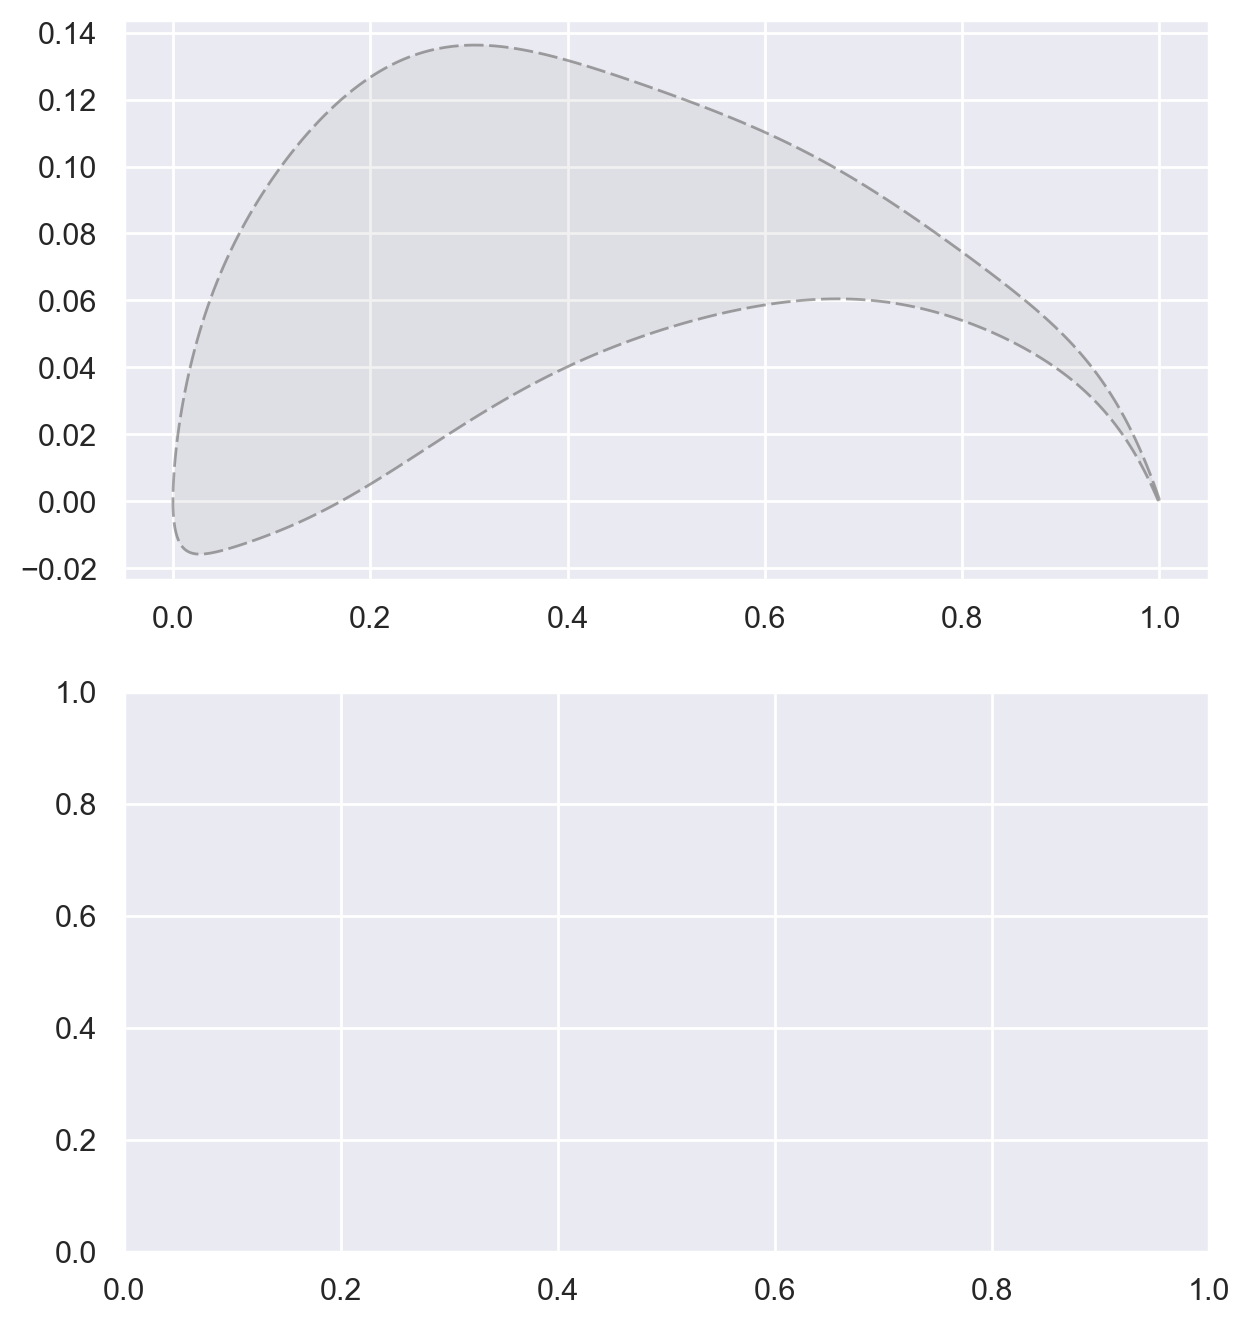

In [49]:
Re_plot = 5e5
fig, ax = plt.subplots(2, 1, figsize=(7,8))

# vanity...
airfoils_and_colors = {
    "Initial Guess"           : (initial_guess_airfoil, "dimgray"),
    "NeuralFoil-Optimized"    : (optimized_airfoil, "blue")
}

for i, (name, (af, color)) in enumerate(airfoils_and_colors.items()):
    color = p.adjust_lightness(color, 1)
    # first plot with airfoil shapes
    ax[0].fill(
        af.x(), af.y(),
        facecolor=(*color, 0.09),
        edgecolor=(*color, 0.6),
        linewidth=1,
        label=name,
        linestyle=(3*i, (7,2)),
        zorder=4 if "NeuralFoil" in name else 3,
    )

    aero = asb.XFoil(
        airfoil=af,
        Re=Re_plot,
        mach=mach,
        timeout=30,
    ).alpha(np.linspace(0, 15, 41), start_at=5)
    # second plot with aerodynamic polars
    ax[1].plot(
        aero["CD"], aero["CL"], #"--",
        color=color, alpha=0.7, label=name,
        zorder=4 if "NeuralFoil" in name else 3,
    )

ax[0].legend(fontsize=11, loc="lower right", ncol=len(airfoils_and_colors)//2)
ax[0].set_title("Airfoil Shapes")
ax[0].set_xlabel("$x/c$")
ax[0].set_ylabel("$y/c$")
ax[0].axis('equal')

ax[1].legend(fontsize=11, loc="lower right", ncol=len(airfoils_and_colors)//2)
ax[1].set_title(f"Aerodynamic Polars (analyzed with XFoil, Re=5e5)")
ax[1].set_xlabel("Drag Coefficient $C_D$")
ax[1].set_ylabel("Lift\nCoefficient\n$C_L$")
ax[1].set_xlim(0, 0.04)
ax[1].set_ylim(0, 1.8)

p.show_plot("Comparison of NeuralFoil-Optimized vs Initial Guess Airfoil", legend=False)

/opt/anaconda3/lib/python3.13/site-packages/executing/executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
/opt/anaconda3/lib/python3.13/ast.py:602: DeprecationWarning: Constant.__init__ got an unexpected keyword argument 's'. Support for arbitrary keyword arguments is deprecated and will be removed in Python 3.15.
  return Constant(*args, **kwargs)
/opt/anaconda3/lib/python3.13/ast.py:602: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
/opt/anaconda3/lib/python3.13/ast.py:602: DeprecationWarning: Constant.__init__ missing 1 required positional argument: 'value'. This will become an error in Python 3.15.
  return Constant(*args, **kwargs)


FileNotFoundError: [Errno 2] No such file or directory: 'xfoil'

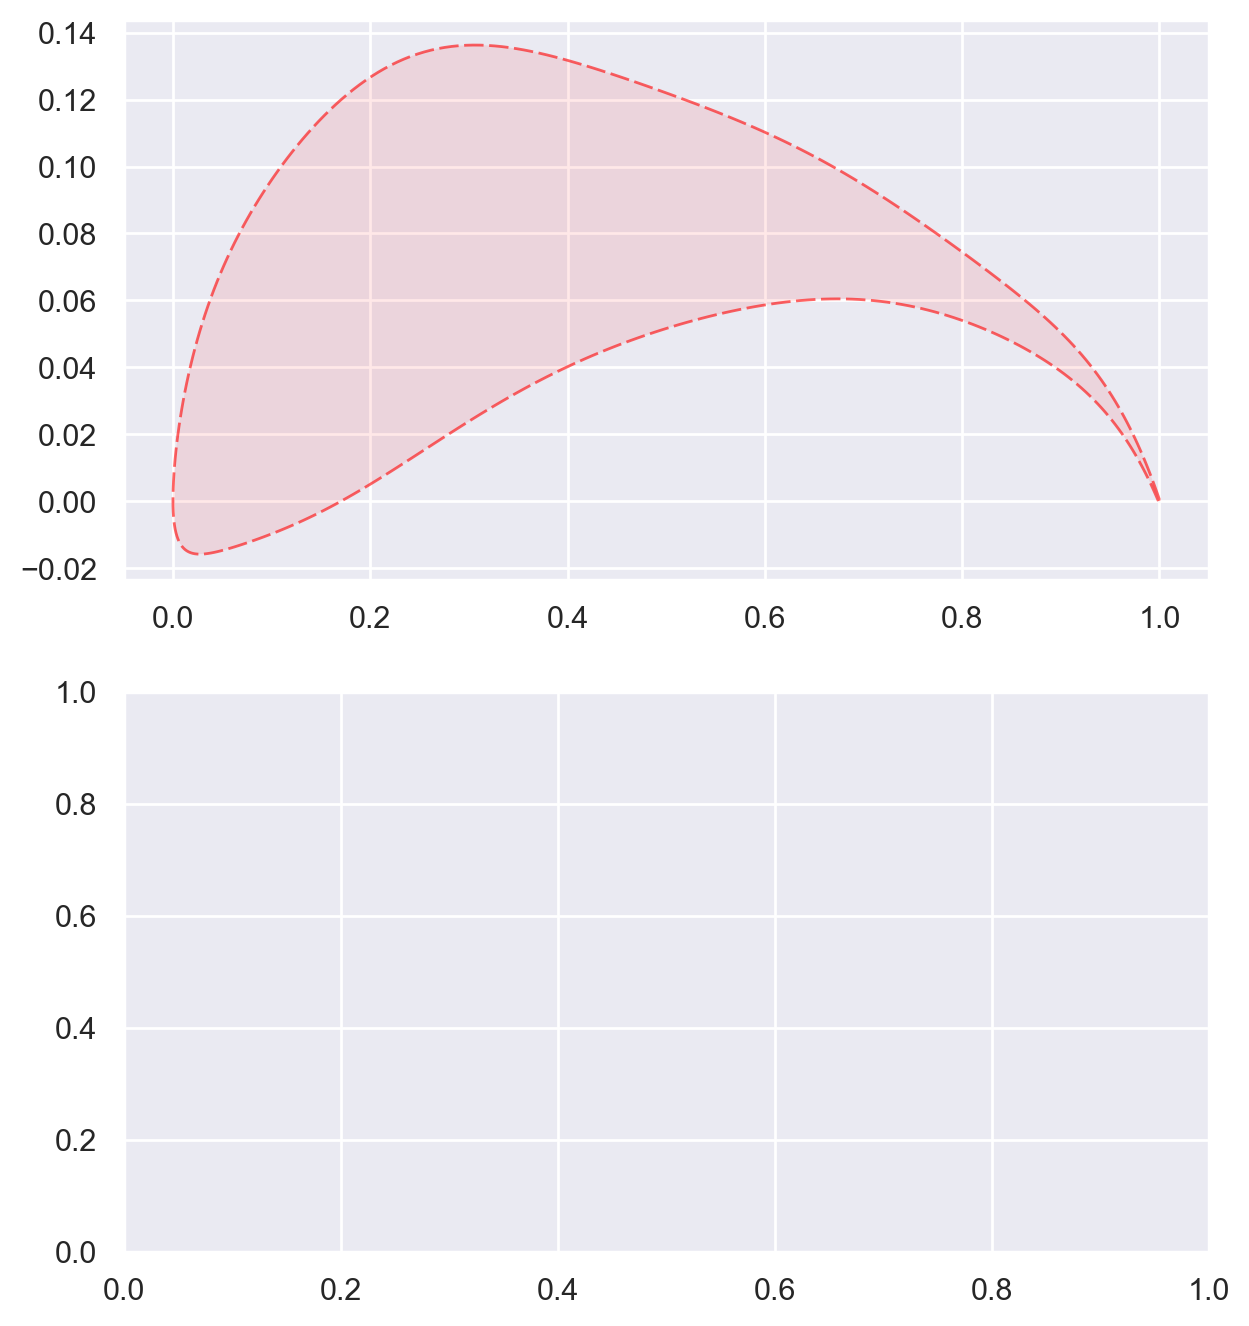

In [54]:
fig, ax = plt.subplots(2, 1, figsize=(7,8))

airfoils = [initial_guess_airfoil, optimized_airfoil]
colors = ['red', 'blue']

for af, color in zip(airfoils, colors):
    color = p.adjust_lightness(color, 1)
    ax[0].fill(
        af.x(), af.y(),
        facecolor=(*color, 0.09),
        edgecolor=(*color, 0.6),
        linewidth=1,
        label=name,
        linestyle=(3*i, (7,2)),
    )

    aero = asb.XFoil(
        airfoil=af,
        Re=Re_plot,
        mach=mach,
        timeout=30,
    ).alpha(np.linspace(0, 15, 41), start_at=5)

Airfoil initial guess (Kulfan / CST parameterization)